In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser

# Lade Merkmal-Daten

In [78]:
from enum import Enum

class tableNames(Enum):
    features_sampleData= "features_sampleData"
    top40k_19_20_features = "top40k_19_20_features"
    top40k_features = "top40k_features"
    
current_table = tableNames.top40k_features.value

In [79]:
filename = '{}.json'.format(current_table)

if filename not in os.listdir("./data"):
    %env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json 
    client = bigquery.Client()
    tableName = 'masterarbeit-245718.ethereum_us.{}'.format(current_table)
    query = "SELECT * from `" + tableName +"`"; 
    query_job = client.query(query);
    start = time.time();
    data = query_job.result().to_dataframe(); 
    data = data.fillna(0.)
    addresses = data["address"]
    featureValues = data.drop("address", axis=1) 
    done = time.time();
    elapsed = round(done - start);
    print("Time to retrieve data from BigQuery: {} Seconds.".format(elapsed))
    with open('./data/{}'.format(filename), 'w') as json_file:
        json.dump(data.to_dict(), json_file, use_decimal=True)
else: 
    print("Loading data from local cache.")
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
    data = pd.DataFrame(file_content_json)
    addresses = data["address"]
    featureValues = data.drop("address", axis=1) 

Loading data from local cache.


In [80]:
m = featureValues.memory_usage();
totalBytes = m.sum();
totalMegabytes = totalBytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(totalMegabytes)))

Size of the account feature dataset: 2.0 Megabytes.


# avgTimeDiff Null Values auf max * 2 setzen

In [81]:
featureValues["avgTimeDiffBetweenSentTransactions"] = featureValues["avgTimeDiffBetweenSentTransactions"].replace(to_replace=0.0, value=2 * max(featureValues["avgTimeDiffBetweenSentTransactions"]))
featureValues["avgTimeDiffBetweenReceivedTransactions"] = featureValues["avgTimeDiffBetweenReceivedTransactions"].replace(to_replace=0.0, value=2 * max(featureValues["avgTimeDiffBetweenReceivedTransactions"]))

# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

In [82]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
featureValues_std.index = featureValues.index

# Use Isolationforest to remove outliers

In [83]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(max_samples="auto", behaviour='new', contamination="auto")
# clf.fit(featureValues_std)
# pred = clf.predict(featureValues_std)
# pred = pd.Series(pred)
# pred.index = featureValues.index
# featureValues_std_out = featureValues_std[pred == 1]
# featureValues_out = featureValues[pred == 1]
# print("Number of detected and deleted outliers: {}".format(pred.value_counts()[-1]))

In [84]:
#  addresses[pred == -1]

### Problem: Isolation forest haut mir die exchanges als Gruppe raus. 

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [85]:
minExplainedVariance = 0.9

In [86]:
pca = PCA().fit(featureValues_std)
optimalNumberOfClusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimalNumberOfClusters = optimalNumberOfClusters + 1
    if i > minExplainedVariance:
        break;

text = "Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimalNumberOfClusters, minExplainedVariance*100);
display(text)

'Die 5 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.'

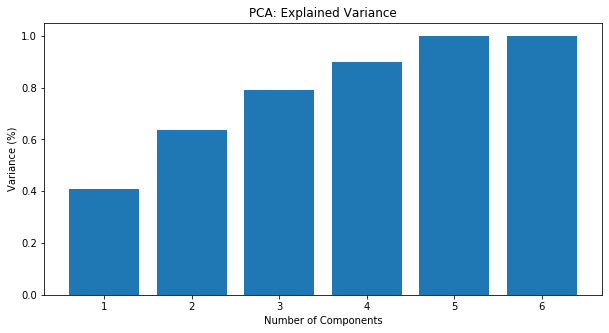

In [87]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()
plt.close()

In [88]:
pca = PCA(n_components=optimalNumberOfClusters);
featureValues_std_pca = pca.fit_transform(featureValues_std);
featureValues_std_pca = pd.DataFrame(featureValues_std_pca);
featureValues_std_pca.index = featureValues.index
featureValues_std_pca.head()

,0,1,2,3,4
0,-0.086879,0.478848,-0.004689,-1.083609,-0.008245
1,-0.086545,0.478862,-0.004884,-1.083614,-0.008324
2,-0.018799,-0.728819,-0.011857,0.127679,0.002680
3,-0.005926,-0.949301,-0.013393,0.348719,0.004556
4,0.005342,-0.965738,-0.019359,0.365948,0.002304


# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [89]:
def estimateNumberOfClusters(featureValues, featureValues_std_pca, maxNumberOfClusters):
    scores = []
    numberOfCluster = []

    for i in range(2,maxNumberOfClusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(featureValues_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimalNumberOfClusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimalNumberOfClusters;

In [90]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [91]:
scores = []
numberOfCluster = []
maxNumberOfClusters = 10

for i in range(2, maxNumberOfClusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(featureValues_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimalNumberOfClusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

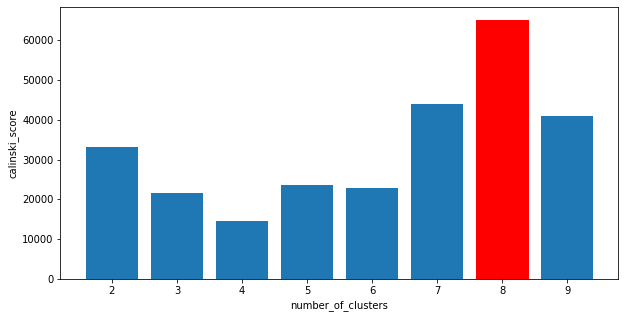

The optimal number of clusters is 8.


In [92]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimalNumberOfClusters))

# Change optimal number manually

In [93]:
# optimalNumberOfClusters = 8 # tmp

# Ausreißer eliminieren

**Todo**: *Prüfen in wie weit hierdurch wie bei Isolation Forest die exchange addresses rausgehauen werden.*

In [94]:

# def remove_outliers(featureValues, featureValues_std_pca, kmeans, threshold):
    
#     featureValues_std_pca_within_cluster_new = pd.DataFrame();
#     featureValues_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         featureValues_std_pca_within_cluster = featureValues_std_pca[kmeans_opt.labels_ == clusterNumber];
#         featureValues_within_cluster = featureValues[kmeans_opt.labels_ == clusterNumber];
            
#         distances = featureValues_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(featureValues_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         featureValues_std_pca_within_cluster_new = featureValues_std_pca_within_cluster_new.append(featureValues_std_pca_within_cluster[keep])
#         featureValues_within_cluster_new = featureValues_within_cluster_new.append(featureValues_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in featureValues_within_cluster[keep].iterrows()])
        
#     return featureValues_std_pca_within_cluster_new, featureValues_within_cluster_new, labels_new

In [95]:
# kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
# kmeans_opt.fit(featureValues_std_pca)

In [96]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(featureValues, featureValues_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [97]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [98]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [99]:
# featureValues, featureValues_std_pca, labels = remove_outliers(featureValues, featureValues_std_pca, kmeans_opt, optimalThreshold)
# featureValues_std_pca = pd.DataFrame(featureValues_std_pca)
# featureValues = pd.DataFrame(featureValues)

# Visualisierung: T-SNE

In [100]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# featureValues_std_pca_out_tsne = tsne.fit_transform(featureValues_std_pca_out)
# featureValues_std_pca_out_tsne = pd.DataFrame(featureValues_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# featureValues_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [101]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# featureValues_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# featureValues_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=featureValues_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Visualisierung PCA 3D Diagramm

In [102]:
# from mpl_toolkits.mplot3d import Axes3D
# # To getter a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions
# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(featureValues_out)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

In [103]:
kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
kmeans_opt.fit(featureValues_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

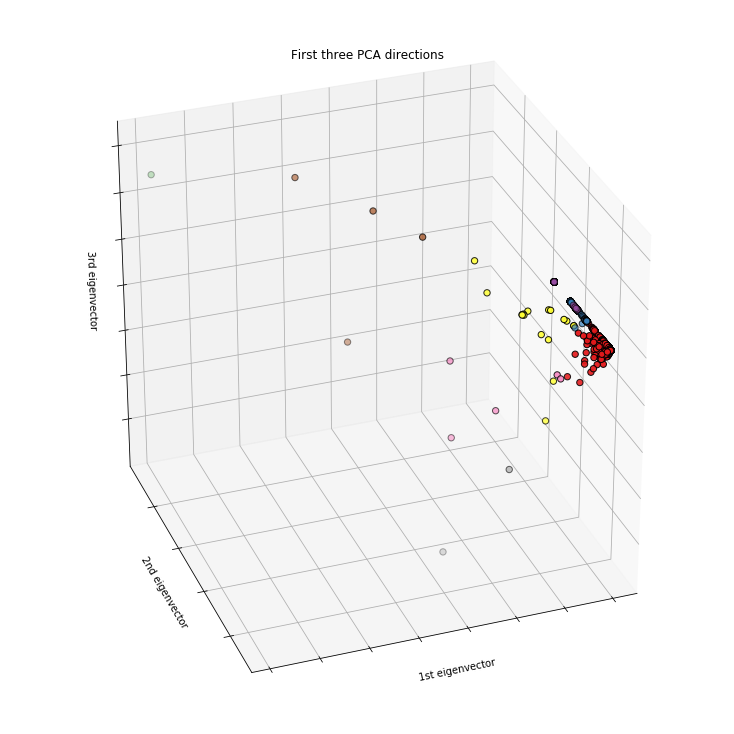

In [104]:
from mpl_toolkits.mplot3d import Axes3D;
# To getter a better understanding of interaction of the dimensions;
# plot the first three PCA dimensions;
fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
X_reduced = PCA(n_components=3).fit_transform(featureValues_std);


ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_, cmap=plt.cm.Set1, edgecolor='k', s=40);
ax.set_title("First three PCA directions");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

# Vergleich der Ballungen

In [163]:
from collections import Counter
cluster_sizes = Counter(kmeans_opt.labels_)

cluster_data = {}

for cluster_label, cluster_size in cluster_sizes.most_common():
    featureValues_in_cluster = featureValues[kmeans_opt.labels_==cluster_label]
    cluster_data[cluster_label] = pd.Series([cluster_size], index=["cluster_size"])
    cluster_data[cluster_label] = cluster_data[cluster_label].append(featureValues_in_cluster.mean())
    
    
cluster_data = pd.DataFrame(cluster_data).T
cluster_data["avgTimeDiffBetweenReceivedTransactions"] = [ timedelta(seconds=s) for s in cluster_data["avgTimeDiffBetweenReceivedTransactions"]]
cluster_data["avgTimeDiffBetweenSentTransactions"] = [ timedelta(seconds=s) for s in cluster_data["avgTimeDiffBetweenSentTransactions"]]
cluster_data["cluster_size"] = cluster_data["cluster_size"].astype("int")

In [164]:
cluster_data

,cluster_size,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,21313,1.518233e+22,1.302692e+22,1.891423e+03,2.615673e+03,43 days 20:21:44.119298,132 days 11:00:27.180137
1,12777,2.797282e+21,3.883587e+19,1.556513e+02,3.144713e-01,2164 days 08:45:54,176 days 13:57:04.052219
3,5881,1.659681e+21,2.874902e+20,1.024486e+00,2.438871e+00,1901 days 17:31:56.641236,36401 days 12:16:24
4,17,1.208338e+25,1.176010e+25,4.393109e+05,1.362941e+06,1 days 09:33:17.164988,0 days 22:46:53.710578
6,5,4.837773e+24,4.261630e+24,7.329850e+06,1.470235e+06,0 days 00:01:35.133170,0 days 00:00:10.496553
5,4,4.279465e+25,4.270121e+25,1.911704e+06,2.796073e+06,0 days 00:01:41.120712,0 days 00:02:17.878490
7,2,5.215705e+24,5.320357e+24,1.559232e+06,1.957603e+07,0 days 00:00:07.332442,0 days 00:01:31.695997
2,1,7.469888e+25,7.447582e+25,6.613297e+06,3.705659e+06,0 days 00:00:21.266143,0 days 00:00:11.916552


# Vergleich der Ballungen durch Visualisierung

In [106]:
cluster_means = []
cluster_size = {}

for i, center in enumerate(kmeans_opt.cluster_centers_):
    within_cluster_featureValues = featureValues[kmeans_opt.labels_==i]
    cluster_size[i] = len(within_cluster_featureValues)
    cluster_means.append(within_cluster_featureValues.mean())

cluster_means = pd.DataFrame(cluster_means)
cluster_data = cluster_means / cluster_means.sum()
cluster_means["cluster_size"] = list(cluster_size.values())
cluster_data["cluster_size"] = list(cluster_size.values())

In [107]:
cluster_data = cluster_data.sort_values(by="cluster_size", ascending=False)
cluster_data = cluster_data.reset_index(drop=True)

In [108]:
cluster_means = cluster_means.sort_values(by="cluster_size", ascending=False)
cluster_means = cluster_means.reset_index(drop=True)
cluster_means["avgTimeDiffBetweenReceivedTransactions"] = [ timedelta(seconds=s) for s in cluster_means["avgTimeDiffBetweenReceivedTransactions"]]
cluster_means["avgTimeDiffBetweenSentTransactions"] = [ timedelta(seconds=s) for s in cluster_means["avgTimeDiffBetweenSentTransactions"]]

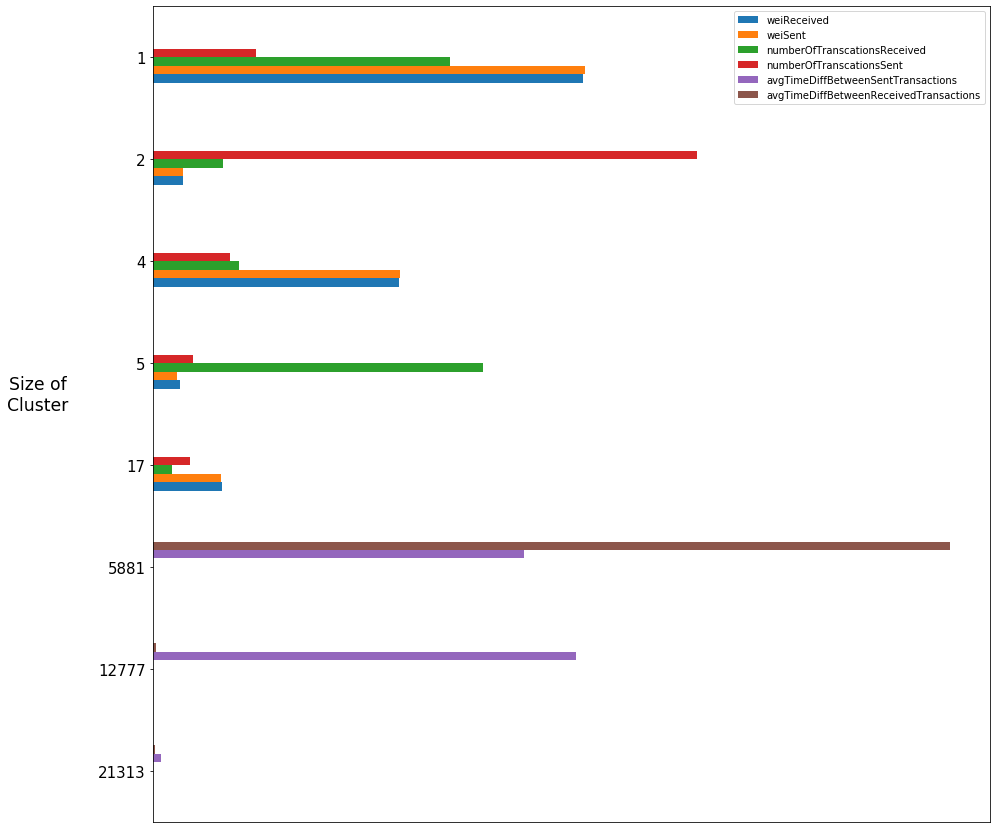

In [224]:
cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

ax.tick_params(
    which="major",
    axis='x', 
    bottom=False
    )

ax.tick_params(
    which="major",
    axis='y', 
    labelsize=15
    ) 

ylabels = ax.get_yticklabels()

ax.set_xticklabels([])
ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

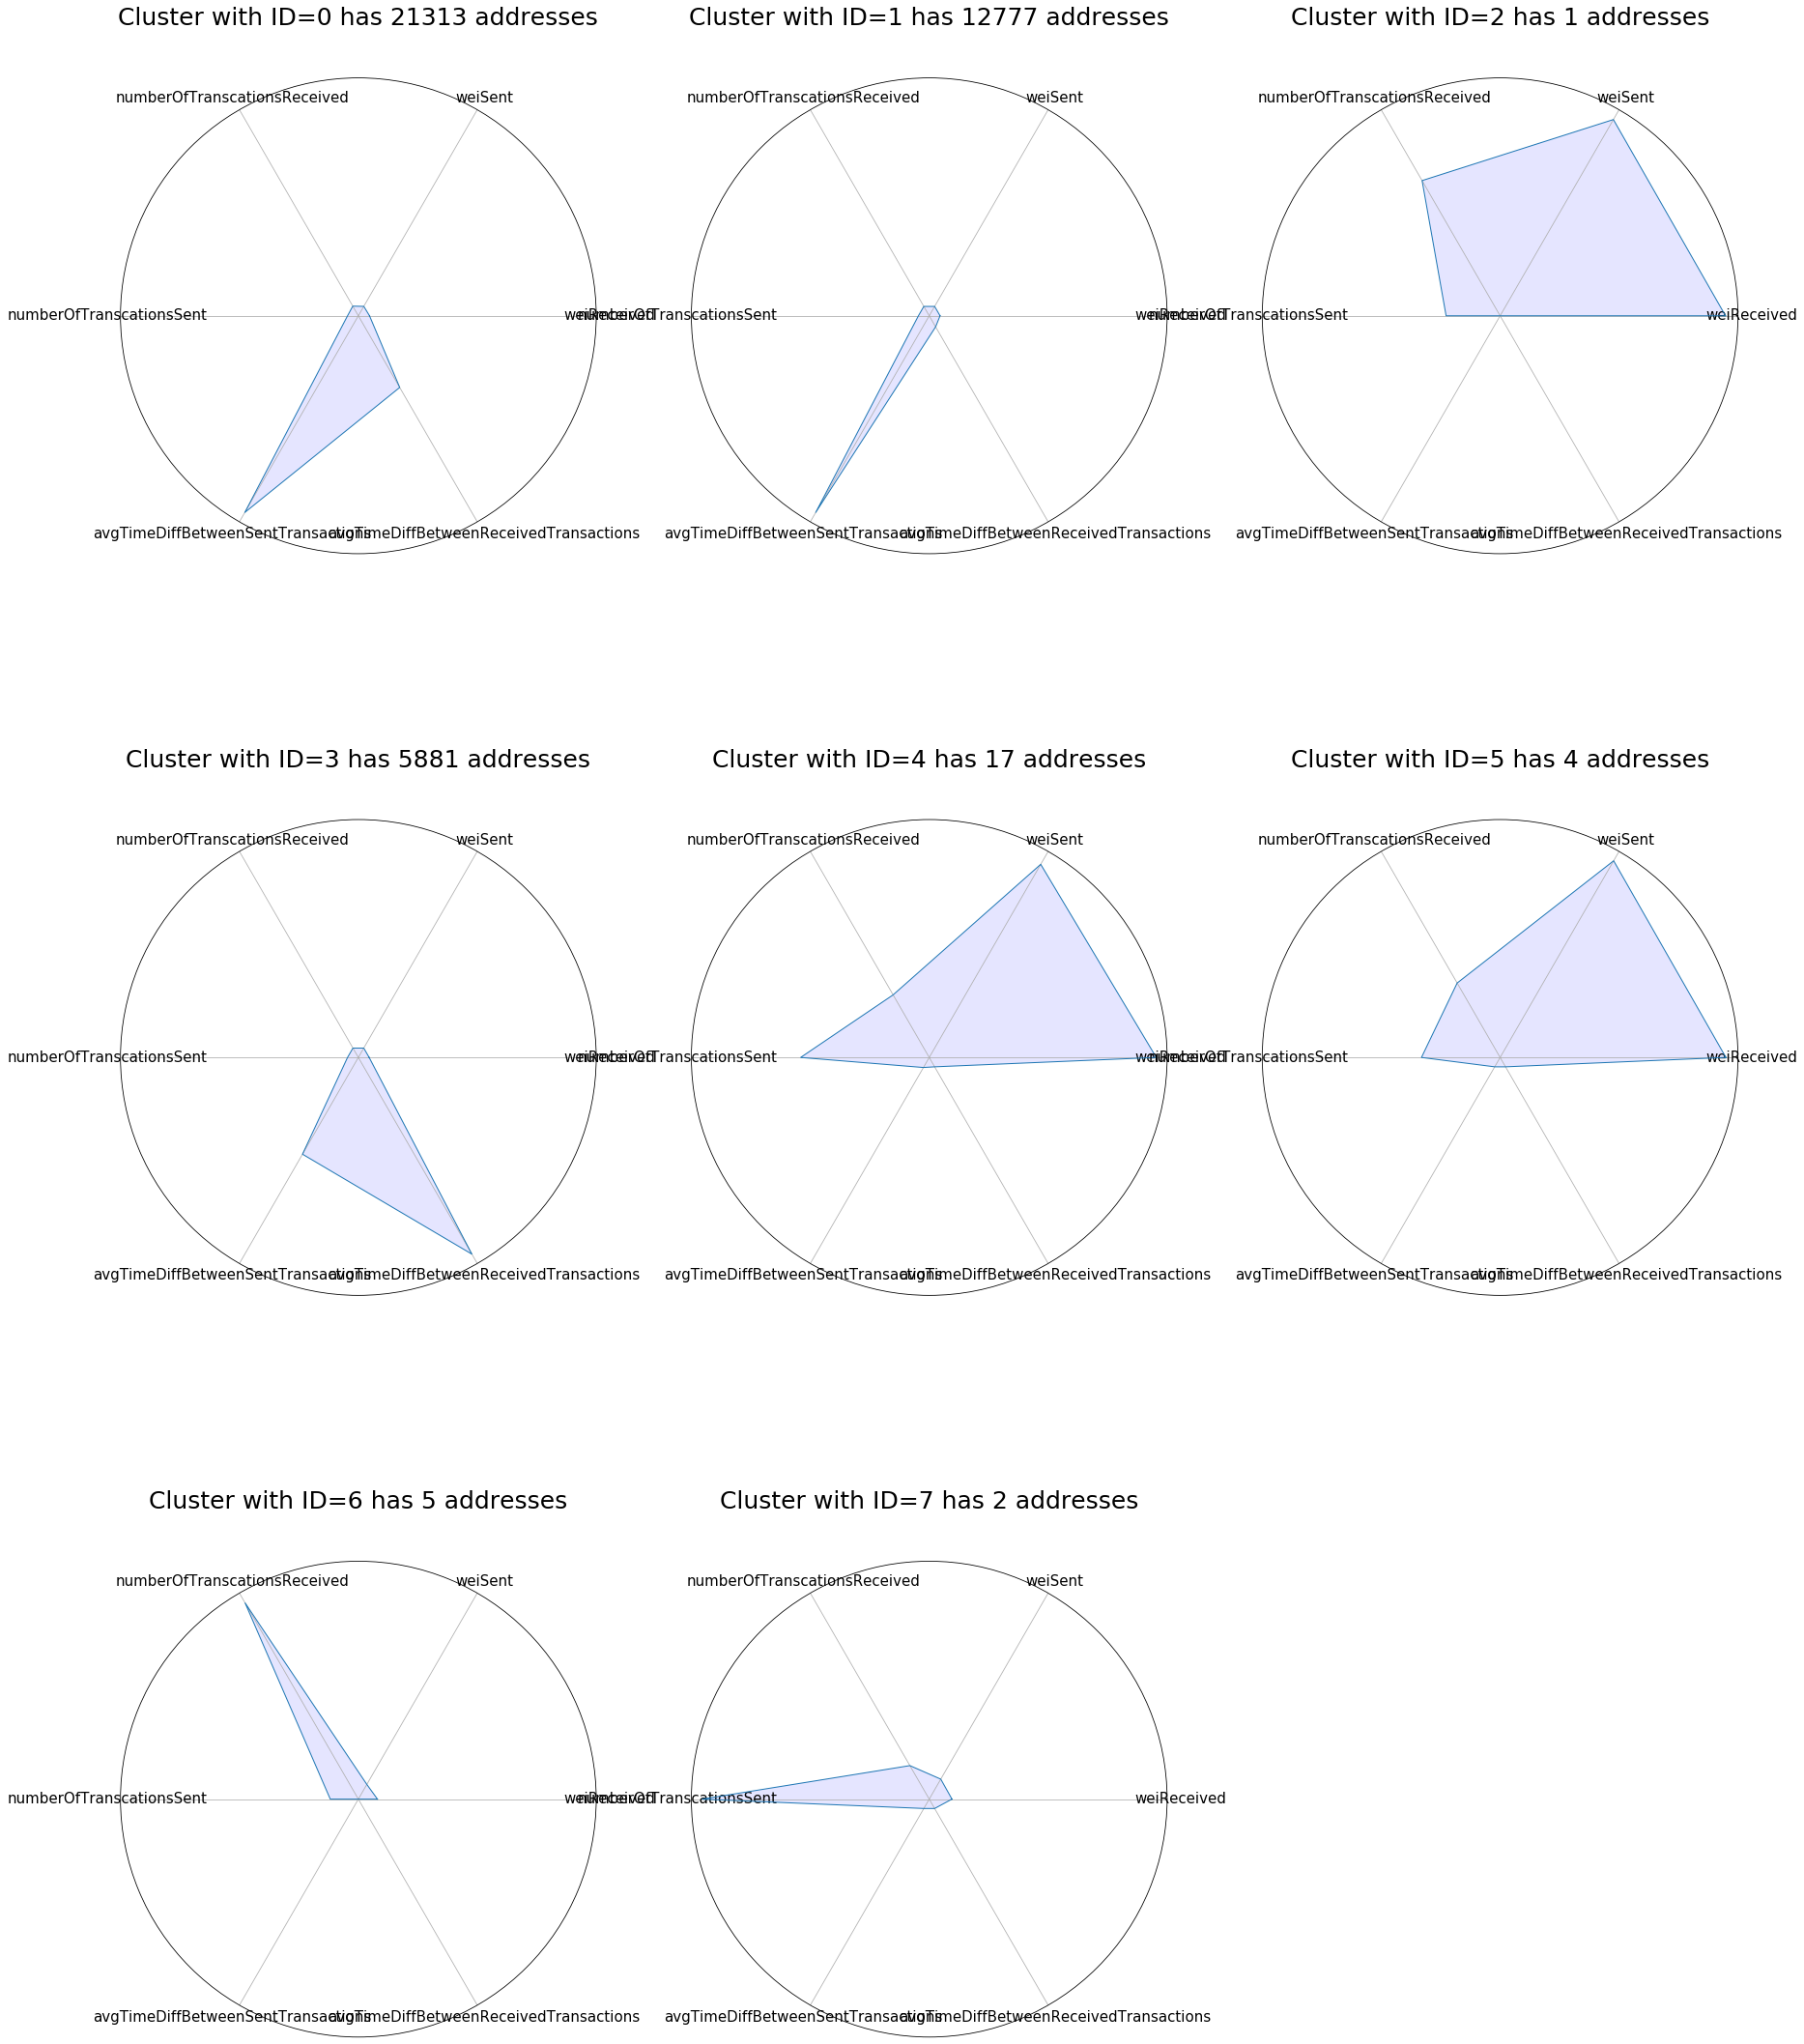

In [228]:
from math import pi

cluster_data_for_plot2 = cluster_data_for_plot1.copy()
cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
# cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

categories=list(cluster_data_for_plot2)
N = len(categories)

values = {}

for i,v in cluster_data_for_plot2.iterrows(): 
    tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values[i] = tmp_values

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles
 
plt.figure(figsize=(30,40))

for cluster_label, cluster_values in values.items():
#     print(cluster_size[i])
    position = int("".join([str(33), str(cluster_label + 1)]))
    axis = plt.subplot(position, polar=True)
    plt.sca(axis)
    plt.xticks(angles[:-1], categories, size=15)
    plt.yticks([])
    axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
    axis.fill(angles, cluster_values, 'b', alpha=0.1)
#     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
    axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)


In [229]:
for i,cd in cluster_data.iterrows():
    x = addresses[kmeans_opt.labels_==i]
    print("Length of cluster with id={}: {}".format(i, len(x)))
    display(x)
    print("############################")

Length of cluster with id=0: 21313


2        0x5e5bab2f9ba0a965d90a471dc3c9912891147f7b
3        0xe06557a578ce51d0db91a5f5a68f0d25bae7a763
4        0x00d681a7b6584f978f63c81cfd847064ce19a080
5        0xa4bc74b650241ae2f90225b5789d687c2e26b440
6        0x913961c89d6a10a1e334d3db0da53934ff786f1f
                            ...                    
39995    0x832b52b8f40666f5c94b86ca7872b67045a7ddaf
39996    0x8de0d002dc83478f479dc31f76cb0a8aa7ccea17
39997    0x0f1131dbff30a569fac2e2941b34131d6a186fb6
39998    0x95151e4615c5c0924b918c85ad8d8a94d6644ab3
39999    0x63a9975ba31b0b9626b34300f7f627147df1f526
Name: address, Length: 21313, dtype: object

############################
Length of cluster with id=1: 12777


0        0x82a3d2f49c91726b80b0df27e38f8b87eb29719f
1        0x71b3cf6391e811d3bb14f801f92c0b3a7d6af3b6
5825     0xbe9e5551775741e3165f7ed9e5c8622a709d3006
5839     0x486bff76de9001720ef6c4be54c32d8fc74ff3bf
5840     0xc85c02f528f13b879f1f7487011d8f9b17f0e7e9
                            ...                    
39943    0x8102ef0a5a7783d103fa54b52b0b5aefb5f08f8b
39950    0x40faac12b53446bc72188704fa8d818dcfcdf74a
39960    0xd311339fa38a6d3d00ef6f4fc63ad4008bec8329
39973    0x7158acb4b88a1d380be279a9c330a47d2d5fd23a
39981    0x6e5e0ef477db8e26cd64f87522a1997f6dda64fb
Name: address, Length: 12777, dtype: object

############################
Length of cluster with id=3: 5881


12       0xad1d2265bacefdc94636b9b2ba0a324aa29b4372
13       0x92cded599bd933c91619235b0bdda3e80ee59851
14       0x66aa7a7560fe0f941da86ab4412f64a77dead8e9
15       0x7fd73a8e087ec9061bb6f9bdc2b3a56fcd7ca181
16       0xe7c942a6c3e0bf432e4dd6dd3cc67294877da125
                            ...                    
20827    0xc451daccddf2781be75b4502e3fb85edf4c4c54c
22201    0xb86536e2cd0dd7465986d964e0858d36c1c7ed30
23524    0x459ed6cce13cb983cb70aeb4e6ccaf8564b478ad
25499    0xfcff7762fa44d838215040ea60d2fbf204bd71ed
27023    0x5aea43a4d9be6e23788828c72fd726199bd43c3d
Name: address, Length: 5881, dtype: object

############################
Length of cluster with id=4: 17


16807    0x008024771614f4290696b63ba3dd3a1ceb34d4d9
18875    0x742d35cc6634c0532925a3b844bc454e4438f44e
22097    0x167a9333bf582556f35bd4d16a7e80e191aa6476
26964    0x1522900b6dafac587d499a862861c0869be6e428
36051    0x6cc5f688a315f3dc28a7781717a9a798a59fda7b
36258    0xe853c56864a2ebe4576a807d26fdc4a0ada51919
36880    0xbf4ed7b27f1d666546e30d74d50d173d20bca754
37383    0x564286362092d8e7936f0549571a803b203aaced
38033    0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae
38150    0x829bd824b016326a401d083b33d092293333a830
38197    0x53d284357ec70ce289d6d64134dfac8e511c8a3d
38352    0x0681d8db095565fe8a346fa0277bffde9c0edbbf
38867    0x2910543af39aba0cd09dbb2d50200b3e800a63d2
39250    0x0d0707963952f2fba59dd06f2b425ace40b492fe
39519    0xd551234ae421e3bcba99a0da6d736074f22192ff
39538    0x70faa28a6b8d6829a4b1e649d26ec9a2a39ba413
39908    0x2a65aca4d5fc5b5c859090a6c34d164135398226
Name: address, dtype: object

############################
Length of cluster with id=6: 5


36514    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
37440    0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208
38594    0xc0829421c1d260bd3cb3e0f06cfe2d52db2ce315
39457    0x03cb0021808442ad5efb61197966aef72a1def96
39508    0x8d12a197cb00d4747a1fe03395095ce2a5cc6819
Name: address, dtype: object

############################
Length of cluster with id=5: 4


31761    0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98
32934    0x876eabf441b2ee5b5b0554fd502a8e0600950cfa
37058    0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0
39180    0xd24400ae8bfebb18ca49be86258a3c749cf46853
Name: address, dtype: object

############################
Length of cluster with id=7: 2


35756    0xea674fdde714fd979de3edf0f56aa9716b898ec8
35884    0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5
Name: address, dtype: object

############################
Length of cluster with id=2: 1


34940    0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be
Name: address, dtype: object

############################


# Helper functions to analyse data

In [86]:
def open_etherscan(cluster_id, number_of_addresses):
    for a in np.random.choice(addresses[kmeans_opt.labels_==cluster_id], number_of_addresses):
        webbrowser.open('https://etherscan.io/address/{}'.format(a), new=1)
    
# open_etherscan(5, 5)

# Recall, Precision und F1 score für das Clustering

In [84]:
# exchanges = [(a, "e") for i, a in enumerate(addresses) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(addresses) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # addresses[kmeans_opt.labels_ == 2]

# tmp = pd.DataFrame(zip(addresses, kmeans_opt.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of Addresses", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)